Data Bases 2020 project

# <center>Heroes of Might and Magic (Ashan)</center>

# <center>Social Network</center>

In [6]:
!pip install neo4j

You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [8]:
import pandas as pd
import nltk
from neo4j import GraphDatabase

# Data

<img src="images/network.jpg">

Data sources: Might&Magic: Elemental Guardians, Sœurs de Sang (comic), Heroes VI, Heroes VI: Pirates of the Savage Sea, Heroes VI: Danse Macabre, Might&Magic: Duel of Champions, Might&Magic X: Legacy, Heroes VI: Shades of Darkness, Heroes VII: Trial by Fire, Might&Magic: Heroes Online, Heroes VII: Tales of Ten Years War (story), Heroes VII, Clash of Heroes, Heroes V, Heroes V: Hammers of Fate, Heroes V: Tribes of the East, Dark Messiah of Might&Magic.


In [55]:
nodes_df = pd.read_excel('heroes_nodes.xlsx')

In [12]:
nodes_df.head()

,Hero,Alias,Faction,Race,Gender,Location,Affiliation,Occupation,Status,Last_Appearance
0,Acamas,NaN,Stronghold,Cyclops,Male,Pao Islands,NaN,NaN,Alive,Heroes VI
1,Agar,NaN,Academy,Wizard,Male,Seven Cities,NaN,NaN,Dead,Mentioned
2,Agbeth,NaN,Dungeon,Dark Elf,Male,Ygg-Chall,NaN,NaN,Dead,Heroes VII: Trial by Fire
3,Aguirre,NaN,Necropolis,Vampire,Male,Seven Cities,NaN,Mentor,Dead,Heroes VI
4,Ahribban,NaN,Inferno,Demon,Male,Sheogh,NaN,Prince of Hate,Slain,Heroes VI


In [56]:
edges_df = pd.read_excel('heroes_relations.xlsx')

In [14]:
edges_df.head()

,Hero_1,Hero_2,Relation,State,Since,Previous
0,Acamas,Sandor Griffin,ally,NaN,NaN,NaN
1,Agar,Falagar,grandfather,NaN,NaN,NaN
2,Agar,Alagar,father,NaN,NaN,NaN
3,Agbeth,Hangvul,enemy,NaN,NaN,NaN
4,Agbeth,Ranleth,twin_brother,NaN,NaN,NaN


## Neo4j graph

In [9]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "Asha-uses-all")) 

In [10]:
session = driver.session()

## Nodes

In [293]:
nodes_df.Faction.unique()

array(['Stronghold', 'Academy', 'Dungeon', 'Necropolis', 'Inferno',
       'Haven', 'Sanctuary', 'Sylvan', 'Deity', 'Fortress', 'Academy ',
       'Shantiri'], dtype=object)

In [57]:
nodes = [] 
for idx, row in nodes_df.iterrows(): 
    rows = [row.Hero, row.Alias, row.Faction, row.Race, row.Gender, row.Location, row.Affiliation, row.Occupation, row.Status,
            row.Last_Appearance] 
    nodes.append(rows) 

In [58]:
for l in nodes:
    query = 'CREATE (f:{} {{ name: "{}", alias: "{}", race: "{}", gender: "{}", location: "{}", affiliation: "{}", occupation: "{}", status: "{}",  last_appearance: "{}"}})'.format(l[2], l[0], l[1], l[3], l[4], l[5], l[6], l[7], l[8], l[9])
    session.run(query)

## Relations

In [17]:
edges_df.Relation.unique()

array(['ally', 'grandfather', 'father', 'enemy', 'twin_brother', 'rival',
       'master', 'servant', 'brother', 'son', 'friend', 'nephew',
       'brother_in_law', 'uncle', 'killed', 'husband', 'vassal',
       'defeated', 'suzerain', 'half_brother', 'colleague', 'teacher',
       'wounded', 'cursed', 'cousin', 'half_sister', 'daughter',
       'mistress', 'grand_nephew', 'twin_sister', 'sister', 'lover',
       'foster_mother', 'granddaughter', 'worships', 'adviser',
       'disciple', 'companion', 'mother', 'executed', 'grandson',
       'banished', 'suppressed', 'descendant', 'rebelled', 'acquaintance',
       'spoke_to', 'created', 'friendly_enemy', 'imprisoned', 'student',
       'reverenced', 'sought_to_enthrone', 'fiancee', 'father_in_law',
       'wife', 'niece', 'aunt', 'sister_in_law', 'fiance', 'son_in_law',
       'crush', 'adoptive_son', 'grandmother', 'dethroned', 'freed',
       'ancestor', 'ex', 'trainer', 'ward', 'healed', 'follower',
       'gratitude', 'comrade', 'd

In [59]:
relations = []
for idx, row in edges_df.iterrows(): 
    rows = [row.Hero_1, row.Hero_2, row.Relation, row.State, row.Since, row.Previous] 
    relations.append(rows) 

In [60]:
for l in relations:    
    query = "MATCH (n) WHERE n.name='{}' MATCH(m) WHERE m.name='{}' CREATE (n)-[r:{} {{state: '{}', since: '{}', previous: '{}' }}]->(m)".format(l[0], l[1], l[2], l[3], l[4], l[5])
    session.run(query)

# Functions

<h3>Создать новый узел</h3>

In [7]:
#преобразовать строку запроса
def convert_properties(p): 
    req = ''
    for k, v in p.items():
        if v == None or v.strip() == '':
            req += str(k) + ': ' + '"nan"' + ', '
        else:
            req += str(k.replace("  ", " ").strip()) + ': ' + '"%s"' % v.replace("  ", " ").strip() + ', '
    return '{' + req[:-1].strip(', ') + '}'

In [10]:
convert_properties({'name': 'Fluffy ', 'race': 'Cerberus', 'since': ' '})

'{name: "Fluffy", race: "Cerberus", since: "nan"}'

In [11]:
def add_node(faction, properties={}):
    node = []
    query = 'MERGE (f:{} {})'.format(faction, convert_properties(properties))
    session.run(query)
    res = session.run('match (n) where n.name = "{}" return n'.format(properties['name']))
    for r in res:
        for d in r:
            node.append(d)
    print(f'Successfully created: {node}')

In [256]:
#example
add_node('Inferno', {'name': 'Fluffy', 'race': 'Cerberus'})

Successfully created: [<Record n=<Node id=112 labels={'Inferno'} properties={'race': 'Cerberus', 'name': 'Fluffy'}>>]


<h3>Создать новое отношение</h3>

In [26]:
def add_relations(rel, names={}, properties={}):
    relations = []
    for k, v in names.items():
        query = "MATCH (n) WHERE n.name='{}' MATCH(m) WHERE m.name='{}' CREATE (n)-[r:{} {}]->(m) return n.name, r, m.name".format(
            k, v, rel, convert_properties(properties))
        res = session.run(query)
        for r in res:
            for d in r:
                relations.append(d)
    print(f'Successfully created: {relations}')   

In [317]:
#example
add_relations('pet', {'Fluffy': 'Lorhish'}, {'state': 'friend', 'since': 'unknown'})

Successfully created: ['Fluffy', <Relationship id=7918 nodes=(<Node id=112 labels=set() properties={}>, <Node id=219 labels=set() properties={}>) type='pet' properties={'state': 'friend', 'since': 'unknown'}>, 'Lorhish']


<h3>Изменить свойства узла</h3>

In [25]:
def update_node_properties(nodes, properties):
    new_properties = []
    for node in nodes:
        query = "MATCH (n) WHERE n.name = '{}' SET n = {} RETURN n".format(node, convert_properties(properties))
        res = session.run(query)
        for r in res:
            for d in r:
                new_properties.append(d)
    print(f'Successfully updated: {new_properties}')

In [281]:
#example
update_node_properties(['Fluffy'], {'name': 'Fluffy', 'race': 'Dog', 'status': 'Alive'})

Successfully updated: [<Node id=112 labels={'Inferno'} properties={'race': 'Dog', 'name': 'Fluffy', 'status': 'Alive'}>]


<h3>Изменить свойства отношения</h3>

In [24]:
def update_relation_properties(rel, names={}, properties={}):
    new_relations = []
    for k, v in names.items():
        #иначе - KeyError: name
        query = "MATCH (n {name:" + "'{}'".format(k) + "})-[r:" + "{}".format(rel) + "]->(m {name:" +"'{}'".format(v) + "}) SET r = " + "{} RETURN r".format(convert_properties(properties))
        res = session.run(query)
        for r in res:
            for d in r:
                new_relations.append(d)
    print(f'Successfully updated: {new_relations}')

In [302]:
#example
update_relation_properties('pet', {'Fluffy': 'Lorhish'}, {'since': 'Harry Potter'})

Successfully updated: [<Relationship id=7931 nodes=(<Node id=112 labels=set() properties={}>, <Node id=219 labels=set() properties={}>) type='pet' properties={'since': 'Harry Potter'}>]


<h3>Удалить отношение</h3>

In [36]:
def delete_relations(rel, names={}):
    for k, v in names.items():
        #иначе - 'KeyError: name'
        query = "MATCH (n {name:" + "'{}'".format(k) + "})-[r:" + "{}".format(rel) + "]->(m {name:" +"'{}'".format(v) + "}) DELETE r"
    session.run(query)
    print('Successfully deleted')

In [320]:
#example
delete_relations('knows', {'Fluffy': 'Lorhish'})

Successfully deleted


<h3>Изменить отношение</h3>

In [35]:
def update_relations(prev_rel, new_rel, names={}):
    for k, v in names.items():
        query = "MATCH (n) WHERE n.name='{}' MATCH(m) WHERE m.name='{}' CREATE (n)-[r:{}]->(m)".format(
            k, v, new_rel)   
        session.run(query)
    delete_relations(prev_rel, names)
    print('Successfully updated') 

In [319]:
#example
update_relations('pet', 'knows', {'Fluffy': 'Lorhish'})

Successfully deleted
Successfully updated


<h3>Удалить узел по свойствам</h3>

In [328]:
def delete_node(properties):
    query = 'MATCH (n {}) DELETE n'.format(convert_properties(properties))
    res = session.run(query)
    for r in res:
        print(r)
    print('Successfully deleted')

In [329]:
#example (worked in browser)
delete_node({'name': 'Fluffy', 'race': 'Dog'})

ConstraintError: Cannot delete node<25>, because it still has relationships. To delete this node, you must first delete its relationships.

<h3>Вывести свойства узлов</h3>

In [153]:
def get_node_properties(names):
    properties = []
    for name in names:
        res = session.run('match (n) where n.name = "{}" return properties(n)'.format(name))
        for r in res:
            for d in r:
                properties.append(d)
    return properties

In [155]:
#example
properties = get_node_properties(['Raelag', 'Isabel Greyhound'])
df = pd.DataFrame(properties)
df = df.reindex(columns=sorted(df.columns))
df = df.reindex(columns=(['name'] + list([a for a in df.columns if a != 'name'])))
df.sort_values('name')

,name,affiliation,alias,gender,last_appearance,location,occupation,race,status
1,Isabel Greyhound,nan,nan,Female,Heroes V: Tribes of the East,"Holy Griffin Empire, Ygg-Chall, Holy Unicorn E...","Duchess, Queen",Human,Alive
0,Raelag,Dragon Knights,Agrael,Male,Heroes V: Hammers of Fate,"Irollan, Tarlad, Sheogh, Ygg-Chall","Soulscar Clanlord, Shadowbrand Clanlord, Kha-...",Dark Elf,Alive


<h3>Вывести свойства отношений</h3>

In [33]:
def print_result(properties):
    string = ''
    for p in properties:
        if p[2]['previous'] != 'nan':
            if nltk.pos_tag([p[2]['previous']])[0][1] == 'VBN':
                print(string + p[0] + ' ' + p[2]['previous'] + ' ' + p[3]) 
            elif p[2]['previous'] == 'enemy' or p[2]['previous'] == 'friend':
                print(string + p[0] + ' considered ' +  p[3] + ' as the ' + p[2]['previous']) 
            else:
                print(string + p[0] + ' was the ' +  p[2]['previous'] + ' of ' + p[3])                             
            
            if p[1] == 'enemy' or p[1] == 'friend':
                print(string + p[0] + ' considers ' +  p[3] + ' as the ' + p[1])
            else:
                print(string + p[0] + ' is the ' + p[1] + ' of ' + p[3] + ' since ' + p[2]['since'])
        
        elif p[2]['previous'] == 'nan' and p[2]['state'] != 'nan':
            if nltk.pos_tag([p[1]])[0][1] == 'VBN':
                print(string + p[0] + ' ' + p[1] + ' ' + p[3])             
            elif p[1] == 'enemy' or p[1] == 'friend':
                print(string + p[0] + ' considers ' +  p[3] + ' as the ' + p[1])
            else:               
                print(string + p[0] + ' is the ' + p[1] + ' of ' + p[3])  
            print(string + p[0] + ' is ' + p[2]['state'] + ' with ' + p[3] + ' since ' + p[2]['since'])   
        
        else:
            if nltk.pos_tag([p[1]])[0][1] == 'VBN':
                print(string + p[0] + ' ' + p[1] + ' ' + p[3])             
            elif p[1] == 'enemy' or p[1] == 'friend':
                print(string + p[0] + ' considers ' +  p[3] + ' as the ' + p[1])
            else:               
                print(string + p[0] + ' is the ' + p[1] + ' of ' + p[3])  

In [34]:
def get_relation_properties(names):
    properties = []
    for k, v in names.items():
        res = session.run("MATCH (n {name:" + "'{}'".format(k) + "})-[r]->(m {name:" +"'{}'".format(v) + "}) RETURN n.name, type(r), properties(r), m.name")
        for r in res:
            properties.append([d for d in r])
    return print_result(properties)

In [392]:
#example
get_relation_properties({'Markal': 'Nicolai Griffin', 'Nicolai Griffin': 'Findan', 'Findan': 'Zehir'})

Markal raised Nicolai Griffin
Markal is the master of Nicolai Griffin since Heroes V
Nicolai Griffin is the friend of Findan
Nicolai Griffin is at war with Findan since Heroes V
Findan is the friend of Zehir


<h3>Вывести тип отношения</h3>

In [39]:
def get_relation_type(names):
    rel_type = []
    for k, v in names.items():
        res = session.run("MATCH (n {name:" + "'{}'".format(k) + "})-[r]->(m {name:" +"'{}'".format(v) + "}) RETURN type(r)")
        for r in res:
            rel_type.append([d for d in r])
    return rel_type

In [41]:
#example
get_relation_type({'Asha': 'Urgash'})[0][0]

'sister'

<h3>Вывести узлы по свойствам</h3>

In [117]:
def get_node_by_prop(properties={}):
    names = []
    if 'location' or 'affiliation' or 'occupation' in properties.keys():
        if 'location' not in properties.keys():
            properties['location'] = '7'     
        if  'afiliation' not in properties.keys():
            properties['affiliation'] = '7'
        if 'occupation' not in properties.keys():   
            properties['occupation'] = '7'
        
        query1 = "OPTIONAL MATCH (m) WHERE m.name=name AND (m.location CONTAINS '{}' OR m.affilitian CONTAINS '{}' OR m.occupation CONTAINS '{}') RETURN m.name, labels(m)".format(
            properties['location'], properties['affiliation'], properties['occupation'])
    
        #удалить ключи, использованные в первом запросе
        properties.pop('location', None) and properties.pop('affiliation', None) and properties.pop('occupation', None)
        
        query2 = "MATCH (n {}) WITH n.name as name".format(convert_properties(properties))   
        
        query = query2 + ' ' + query1 
        
    else:
        query = "MATCH (n {}) RETURN n.name, labels(n)".format(convert_properties(properties))  
    
    res = session.run(query)
    
    for r in res:  
        names.append([n for n in r])
    
    return names

In [118]:
#example
names = get_node_by_prop({'race': 'Dark Elf', 'location':'Tarlad'})

In [149]:
for name in names:
    if name[0] != None:
        print(name)

['Eruina', ['Dungeon']]
['Malwen', ['Dungeon']]
['Menan', ['Dungeon']]
['Raelag', ['Dungeon']]
['Salvin', ['Dungeon']]
['Sylsai', ['Dungeon']]
['Tuidhana', ['Dungeon']]
['Vayaron', ['Dungeon']]


<h3>Вывести узлы по типу отношений</h3>

In [153]:
def get_nodes_by_rel(rel):
    relation = []
    query = "MATCH (n)-[r:{}]->(m) RETURN n.name, type(r), m.name".format(rel)
    res = session.run(query)
    for r in res:
        relation.append([i for i in r])
    
    return relation

In [155]:
#example
relation = get_nodes_by_rel('killed')

In [167]:
for r in sorted(relation)[:5]:
    print(r[0] + ' ' + r[1] + ' ' + r[2])

Aidan Unicorn killed Azexes
Alaric killed Khengi
Alaric killed Quroq
Alejandro De La Segadora killed Ovidio Bull
Anastasya Griffin killed Miranda


<h3>Изменить статус убитого персонажа</h3> 
('Slain' - для демонов, 'Dead' - для всех остальных)

In [28]:
def change_status(names={}, properties={}):
    #previous relation
    then = get_relation_properties(names)
    
    #delete previous relation
    for k, v in names.items():
        query1 = "MATCH (n {name:" + "'{}'".format(k) + "})-[r]->(m {name:" + "'{}'".format(v) + "}) DELETE r"
        session.run(query1)
    
    #create new relation
    add_relations('killed', names, properties)
    
    #change status
    for k, v in names.items():
        query2 = "MATCH (n) WHERE n.name='{}' with n, CASE WHEN n.race IN ['Succubus', 'Incubus', 'Demon'] THEN ['Slain'] ELSE ['Dead'] END AS status FOREACH (_ IN status | SET n.status = status)".format(v)
        session.run(query2)
    
    #new relation
    now = get_relation_properties(names)   
     
    #show new status
    status = []
    for k, v in names.items():    
        query3 = "MATCH (n) WHERE n.name='{}' RETURN n.name, n.status".format(v)
        res = session.run(query3)
        for r in res:
            status.append([d for d in r])
        
    print(str(then)) 
    print(str(now))
    return status

In [37]:
status = change_status({'Isabel Greyhound': 'Biara'}, {'state': 'nan', 'since': 'nan', 'previous': 'nan'})

Isabel Greyhound considers Biara as the enemy
Successfully created: ['Isabel Greyhound', <Relationship id=5344 nodes=(<Node id=183 labels=set() properties={}>, <Node id=85 labels=set() properties={}>) type='killed' properties={'previous': 'nan', 'state': 'nan', 'since': 'nan'}>, 'Biara']
Isabel Greyhound killed Biara
None
None


In [38]:
#проверка
status

[['Biara', ['Slain']]]

In [30]:
#проверка
get_relation_type({'Isabel Greyhound': 'Biara'})[0][0]

'killed'

# Analysis

<h3>Подсчитать количество отношений определённого типа для отдельных узлов</h3>

In [453]:
def as_dataframe(results):
    names = []
    rel = []
    count = []
    for el in results:
        names.append(el[0])
        rel.append(el[1])
        count.append(el[2])    
    d = {'Name': names, 'Relation': rel, 'Total': count}   
    
    print(pd.DataFrame(d))

In [454]:
def count_relations(names, rel):
    results = []
    for name in names:
        query = "MATCH (n {name:" + "'{}'".format(name) + "})" + "-[r:{}]-() RETURN n.name, type(r), count(r) as rel_count order by rel_count desc".format(rel)
        res = session.run(query)
        for r in res:
            d = [d for d in r]
            results.append(d)
    
    return as_dataframe(results)

In [456]:
#example
count_relations(['Raelag', 'Deirdre Stag', 'Kha-Beleth'], 'enemy')

           Name Relation  Total
0        Raelag    enemy     18
1  Deirdre Stag    enemy      2
2    Kha-Beleth    enemy     21


<h3>Shortest path</h3>

In [109]:
def shortest_path(names):
    results= []
    for k, v in names.items():
        query = "MATCH p=shortestPath( (n{name:" + "'{}'".format(k) + "}) - [*..] - (m{name:" + "'{}'".format(v) + "}) ) RETURN p"
        res = session.run(query)
        for r in res:
            results.append([i for i in r])    
    return results       

In [110]:
#example
shortest_path({'Freyda Unicorn': 'Ciele'})

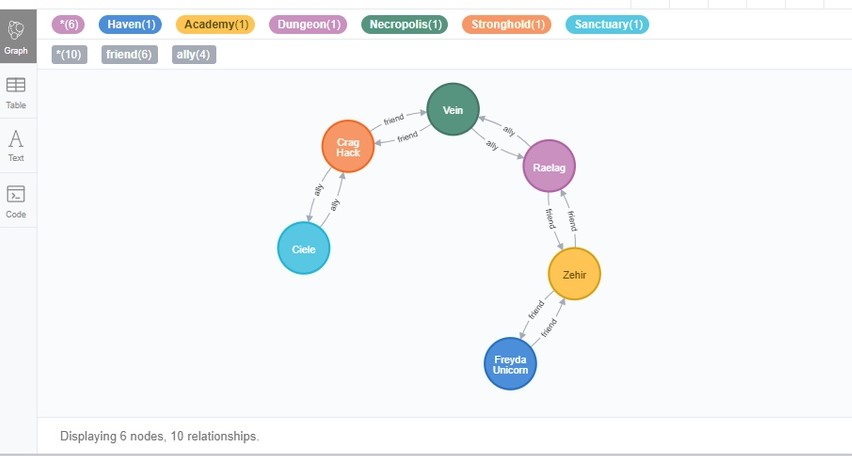

<h3>All shortest paths</h3>

In [97]:
def all_shortest_paths(names={}):
    results= []
    for k, v in names.items():
        query = "MATCH p=allShortestPaths( (n{name:" + "'{}'".format(k) + "}) - [*..] - (m{name:" + "'{}'".format(v) + "}) ) RETURN n.name, count(p), m.name"
        res = session.run(query)
        for r in res:
            results.append([i for i in r])    
    return results

In [99]:
#example
names = {'Kha-Beleth': 'Asha', 'Alejandro De La Segadora': 'Asha'}
results = shortest_paths(names)

In [103]:
df = pd.DataFrame(results, columns=['Name1', 'All Shortest Paths', 'Name2'])
df = df.sort_values('All Shortest Paths', ascending=False)

In [104]:
df

,Name1,All Shortest Paths,Name2
0,Kha-Beleth,8,Asha
1,Alejandro De La Segadora,1,Asha


<h3>Centrality</h3>

In [35]:
def centrality_out():
    results = []
    query = "MATCH (n)-[r]->() RETURN n.name, COUNT(r), n.status, n.last_appearance" #LIMIT 10
    res = session.run(query)
    for r in res:
        results.append([n for n in r])
    
    return results

In [36]:
#example
results = centrality_out()

In [39]:
df = pd.DataFrame(results, columns=['Name', 'Outcoming Relations', 'Status', 'Last Appearance'])
df = df.sort_values('Outcoming Relations', ascending=False)

In [40]:
df.head() #статус указывался на момент последнего появления

,Name,Outcoming Relations,Status,Last Appearance
47,Raelag,44,Alive,Heroes V: Hammers of Fate
0,Sandor Griffin,30,Alive,Might&Magic X: Legacy
13,Anton Griffin,30,Alive,Might&Magic X: Legacy
63,Irina Griffin,29,Alive,Heroes VI
93,Anastasya Griffin,25,Alive,Heroes VII


In [41]:
def centrality_in():
    results = []
    query = "MATCH (n)<-[r]-() RETURN n.name, COUNT(r), n.status, n.last_appearance" #LIMIT 10
    res = session.run(query)
    for r in res:
        results.append([n for n in r])
    
    return results

In [43]:
results = centrality_in()

In [44]:
df = pd.DataFrame(results, columns=['Name', 'Incoming Relations', 'Status', 'Last Appearance'])
df = df.sort_values('Incoming Relations', ascending=False)

In [45]:
df.head()

,Name,Incoming Relations,Status,Last Appearance
135,Raelag,44,Alive,Heroes V: Hammers of Fate
64,Irina Griffin,29,Alive,Heroes VI
0,Sandor Griffin,28,Alive,Might&Magic X: Legacy
11,Anton Griffin,26,Alive,Might&Magic X: Legacy
65,Ivan Griffin,25,Dead,Heroes VII


In [48]:
def centrality_total():
    results = []
    query = "MATCH (n)-[r]-() RETURN n.name, COUNT(r), n.status, n.last_appearance" #LIMIT 10
    res = session.run(query)
    for r in res:
        results.append([n for n in r])
    
    return results

In [49]:
results = centrality_total()

In [50]:
df = pd.DataFrame(results, columns=['Name', 'Relations Total', 'Status', 'Last Appearance'])
df = df.sort_values('Relations Total', ascending=False)

In [51]:
df.head()

,Name,Relations Total,Status,Last Appearance
49,Raelag,88,Alive,Heroes V: Hammers of Fate
0,Sandor Griffin,58,Alive,Might&Magic X: Legacy
65,Irina Griffin,58,Alive,Heroes VI
13,Anton Griffin,56,Alive,Might&Magic X: Legacy
67,Ivan Griffin,48,Dead,Heroes VII


<h3>Closeness</h3>

In [112]:
def closeness():
    results = []
    query = " CALL algo.closeness.stream('MATCH (n) RETURN id(n) AS id', 'MATCH (n)-[r]->(m) RETURN id(n) AS source, id(m) AS target', {graph: 'cypher', direction: 'OUTGOING'}) YIELD nodeId, centrality RETURN algo.asNode(nodeId).name AS node, centrality ORDER BY centrality DESC;"
    res = session.run(query)
    for r in res:
        results.append([n for n in r])
    return results

In [113]:
results = closeness()

In [118]:
df = pd.DataFrame(results, columns=['Name', 'Closeness'])

In [119]:
df[100:].head()

,Name,Closeness
100,Vayaron,0.289559
101,Brendan Stag,0.289247
102,Cyrus,0.289247
103,Fiona Unicorn,0.288937
104,Jon Morgan,0.288937


To be continued...

In [136]:
#закрыть сессию
session.close()

In [137]:
session.closed()

True

In [168]:
#!WARNING!удалить весь граф
#session.run('MATCH (n)-[r]-() DELETE n,r')